In [1]:
import generation as gen
import files
import utils
import os
import models
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
from matplotlib import cm
import seaborn as sns

/Users/mzaffran/Documents/Code/CP/cp-epf/models.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
size=19
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'Times',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': size,
    'axes.labelsize':size,
    'axes.titlesize':size,
    'figure.titlesize':size,
    'xtick.labelsize':size,
    'ytick.labelsize':size,
    'legend.fontsize':size,
})

In [3]:
regression = 'Friedman'
noise = 'ARMA'

var = 10
list_params_noise_ar = [{'ar':[1,-0.1], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.8], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.9], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.95], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.99], 'ma':[1], 'process_variance':var}]
list_params_noise_ma = [{'ar':[1], 'ma':[1,0.1], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.8], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.9], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.95], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.99], 'process_variance':var}]
list_params_noise_arma = [{'ar':[1,-0.1], 'ma':[1,0.1], 'process_variance':var},
                          {'ar':[1,-0.8], 'ma':[1,0.8], 'process_variance':var},
                          {'ar':[1,-0.9], 'ma':[1,0.9], 'process_variance':var},
                          {'ar':[1,-0.95], 'ma':[1,0.95], 'process_variance':var},
                          {'ar':[1,-0.99], 'ma':[1,0.99], 'process_variance':var}]
n = 300
train_size = 200
test_size = n-train_size
n_rep = 500
alpha = 0.1

In [4]:
colors_blindness = sns.color_palette("colorblind")

In [5]:
colors_blindness

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
colors_blindness = sns.color_palette("colorblind")
colors = [colors_blindness[8],colors_blindness[1],colors_blindness[9],colors_blindness[0],colors_blindness[2]]

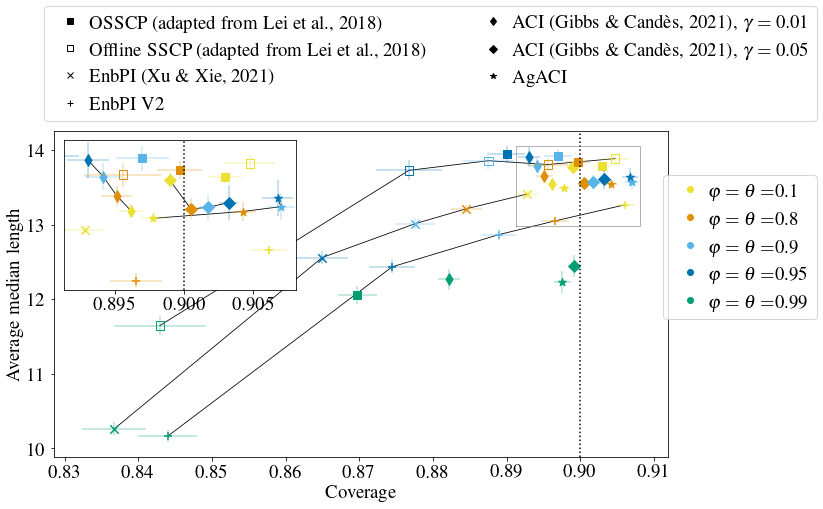

In [7]:
lines = True
add_offline = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']
methods_off = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient','CP_offline']
fig, (ax1) = plt.subplots(1, 1, figsize=(11,6), sharex=True, sharey=True)
axins = zoomed_inset_axes(ax1,1.88,loc='upper left')
markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

if add_offline:
    to_link = dict.fromkeys(methods_off)
    for method in methods_off:
        to_link[method] = {'cov':[],'len':[]}
else:
    to_link = dict.fromkeys(methods)
    for method in methods:
        to_link[method] = {'cov':[],'len':[]}

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        axins.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                     marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        axins.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                       xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                       color=colors[idx], alpha=0.3)
        to_link[method]['cov'].append(np.mean(contains))
        to_link[method]['len'].append(np.mean(np.median(lengths, axis=1)))
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            axins.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                          marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
            axins.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                           xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                           color=colors[idx], alpha=0.3)
            to_link['CP_offline']['cov'].append(np.mean(contains))
            to_link['CP_offline']['len'].append(np.mean(np.median(lengths, axis=1)))
        
if lines:
    for method in ['EnbPI','EnbPI_Mean','CP_offline']:
        ax1.plot(to_link[method]['cov'], to_link[method]['len'], ls='-',color='black',linewidth=0.8,zorder=-1)
    for method in ['ACP_0.01','ACP_0.05','Aggregation_BOA_Gradient']:
        axins.plot(to_link[method]['cov'][:4], to_link[method]['len'][:4], ls='-',color='black',
                   linewidth=0.8,zorder=-1)
ax1.axvline(x=1-alpha, color='black', ls=':')
axins.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average median length")

x1 = 0.8913
x2 = 0.9081
y1 = 12.98
y2 = 14.05
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_yticks([])
ax1.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],linewidth=0.6,color='grey')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,mode='expand',
           ncol=2, bbox_to_anchor=(0.1,0.99,1,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))
fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.8),handletextpad=10**(-16))

if lines:
    name_plot = 'plots/synthetic/Friedman_ARMA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_ARMA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'

name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

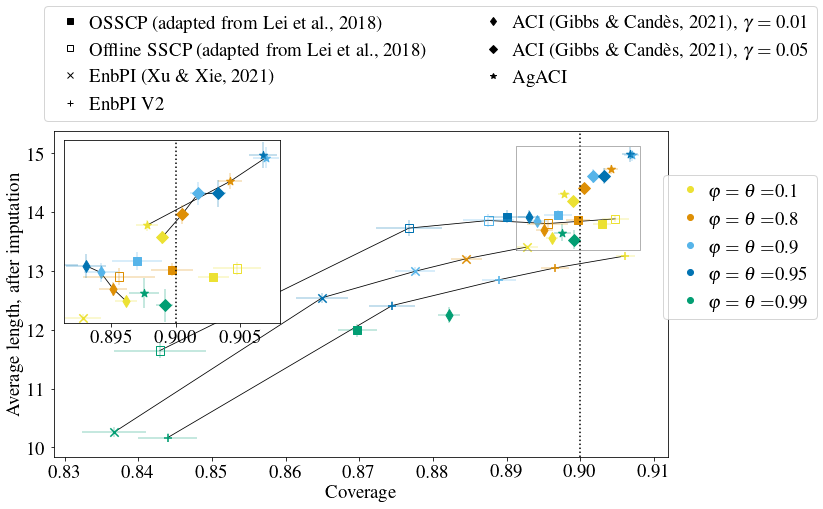

In [20]:
lines = True
add_offline = True

Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']
methods_off = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient','CP_offline']
fig, (ax1) = plt.subplots(1, 1, figsize=(11,6), sharex=True, sharey=True)
axins = zoomed_inset_axes(ax1,1.75,loc='upper left')
markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

if add_offline:
    to_link = dict.fromkeys(methods_off)
    for method in methods_off:
        to_link[method] = {'cov':[],'len':[]}
else:
    to_link = dict.fromkeys(methods)
    for method in methods:
        to_link[method] = {'cov':[],'len':[]}

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, 
                                                     params_noise=params_noise,
                                                     impute=True)
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        axins.scatter(np.mean(contains),np.mean(lengths), 
                     marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        axins.errorbar(np.mean(contains), np.mean(lengths),
                       xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                       color=colors[idx], alpha=0.3)
        to_link[method]['cov'].append(np.mean(contains))
        to_link[method]['len'].append(np.mean(lengths))
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            axins.scatter(np.mean(contains),np.mean(lengths), 
                          marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
            axins.errorbar(np.mean(contains), np.mean(lengths),
                           xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                           color=colors[idx], alpha=0.3)
            to_link['CP_offline']['cov'].append(np.mean(contains))
            to_link['CP_offline']['len'].append(np.mean(lengths))      
if lines:
    for method in ['EnbPI','EnbPI_Mean','CP_offline']:
        ax1.plot(to_link[method]['cov'], to_link[method]['len'], ls='-',color='black',linewidth=0.8,zorder=-1)
    for method in ['ACP_0.01','ACP_0.05','Aggregation_BOA_Gradient']:
        axins.plot(to_link[method]['cov'][:4], to_link[method]['len'][:4], ls='-',color='black',
                   linewidth=0.8,zorder=-1)
ax1.axvline(x=1-alpha, color='black', ls=':')
axins.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average length, after imputation")

x1 = 0.8913
x2 = 0.9081
y1 = 13.35
y2 = 15.13
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_yticks([])
ax1.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],linewidth=0.6,color='grey')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,mode='expand',
           ncol=2, bbox_to_anchor=(0.1,0.99,1,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))
fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.8),handletextpad=10**(-16))
    
if lines:
    name_plot = 'plots/synthetic/Friedman_imputed_ARMA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_imputed_ARMA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'

name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

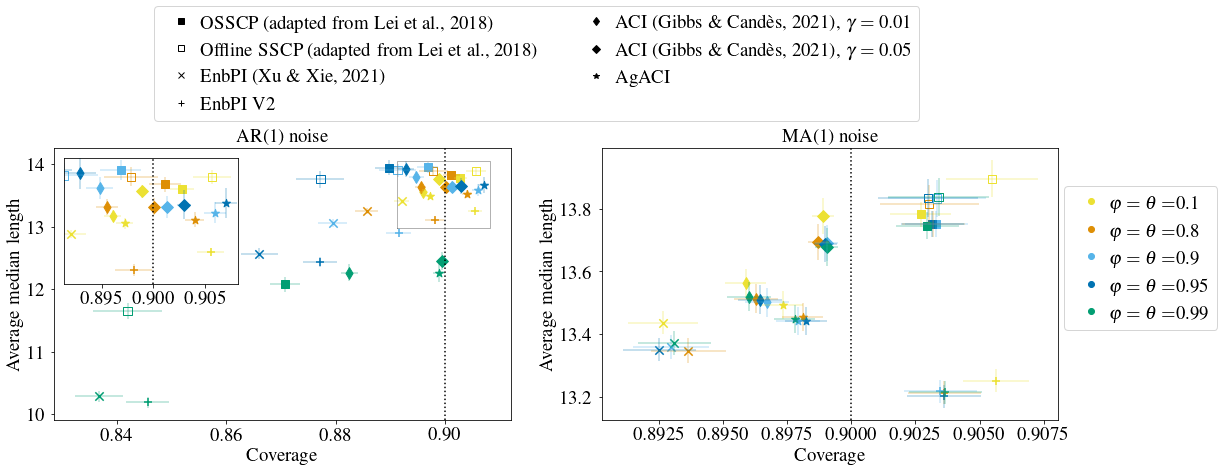

In [29]:
lines = False
add_offline = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']
    
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,5), sharex=False, sharey=False)
axins = zoomed_inset_axes(ax1,1.89,loc='upper left')

markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        axins.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                     marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        axins.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                       xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                       color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            axins.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                          marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
            axins.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                           xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                           color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
axins.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average median length")
ax1.set_title("AR(1) noise")

x1 = 0.8913
x2 = 0.9082
y1 = 12.98
y2 = 14.05
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_yticks([])
ax1.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],linewidth=0.6,color='grey')

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average median length")
ax2.set_title('MA(1) noise')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,
           ncol=2, bbox_to_anchor=(0.1,1.1,0.7,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))#+str(-params_noise['ar'][1])+
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))
    
if lines:
    name_plot = 'plots/synthetic/Friedman_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

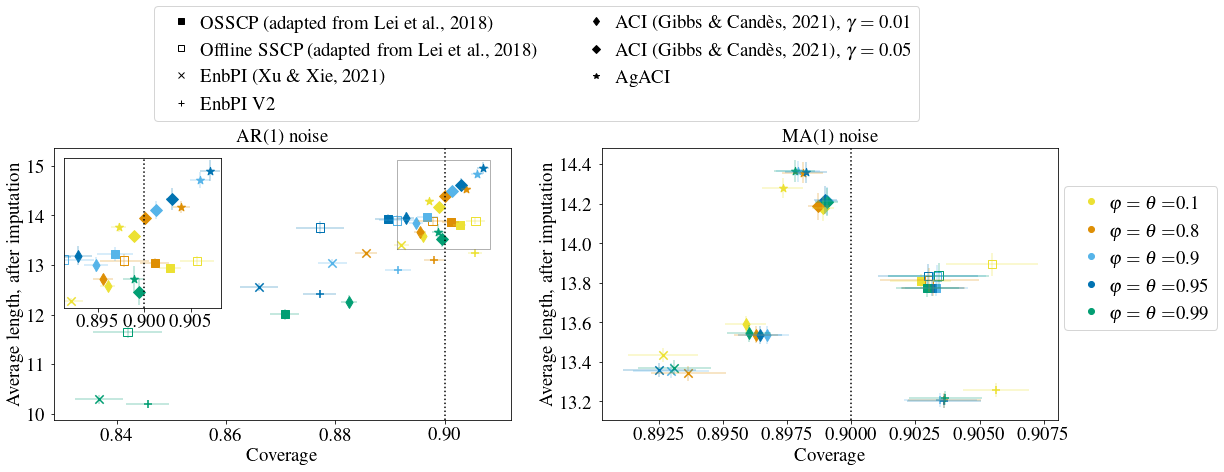

In [36]:
lines = False
add_offline = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']
    
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,5), sharex=False, sharey=False)
axins = zoomed_inset_axes(ax1,1.7,loc='upper left')

markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise,
                                                     impute=True)
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        axins.scatter(np.mean(contains),np.mean(lengths), 
                     marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        axins.errorbar(np.mean(contains), np.mean(lengths),
                       xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                       color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise,
                                                         impute=True)
            ax1.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            axins.scatter(np.mean(contains),np.mean(lengths), 
                          marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
            axins.errorbar(np.mean(contains), np.mean(lengths),
                           xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                           color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
axins.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average length, after imputation")
ax1.set_title("AR(1) noise")

x1 = 0.8913
x2 = 0.9083
y1 = 13.33
y2 = 15.11
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_yticks([])
ax1.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],linewidth=0.6,color='grey')

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise,
                                                     impute=True)
        ax2.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise, impute=True)
            ax2.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average length, after imputation")
ax2.set_title('MA(1) noise')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,
           ncol=2, bbox_to_anchor=(0.1,1.1,0.7,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))#+str(-params_noise['ar'][1])+
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))
    
if lines:
    name_plot = 'plots/synthetic/Friedman_imputed_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_imputed_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

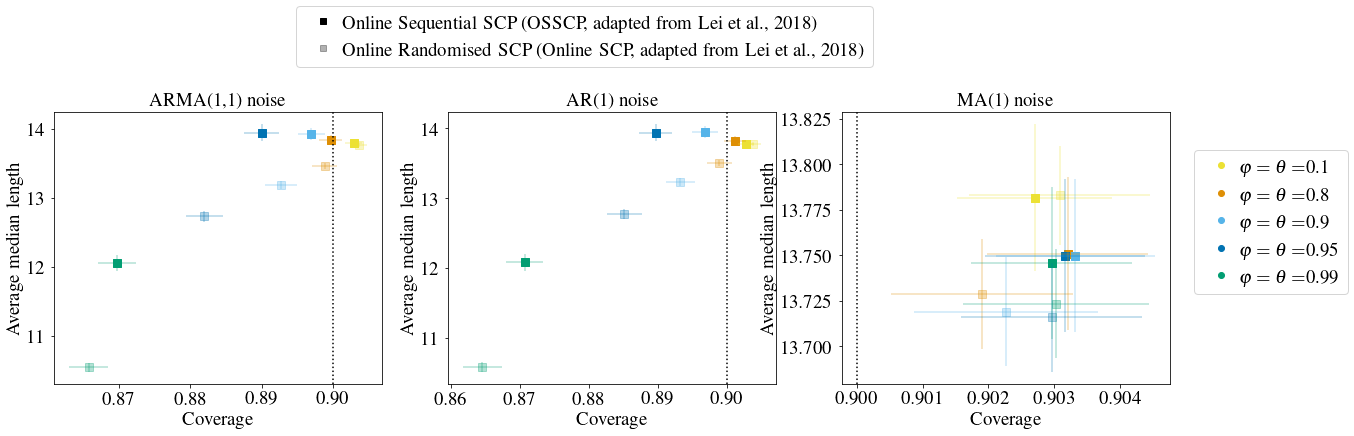

In [10]:
lines = False
add_randomized = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP']
    
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5), sharex=False, sharey=False)

markers = {'CP': "s", 'ACP': "*", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average median length")
ax1.set_title("ARMA(1,1) noise")

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average median length")
ax2.set_title("AR(1) noise")

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax3.axvline(x=1-alpha, color='black', ls=':')
ax3.set_xlabel("Coverage")
ax3.set_ylabel("Average median length")
ax3.set_title('MA(1) noise')

# Methods legend

if add_randomized:
    labels = ['Online Sequential SCP (OSSCP, adapted from Lei et al., 2018)', 
              'Online Randomised SCP (Online SCP, adapted from Lei et al., 2018)']
    handles = [mlines.Line2D([], [], color='black', marker="s", linestyle='None'),
               mlines.Line2D([], [], color='black', marker="s", linestyle='None', alpha=0.3)]
    fig.legend(handles, labels, bbox_to_anchor=(0.1,1,0.6,0.2),handletextpad=10**(-16))
    
# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))
    
if lines:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_randomized :
    name_plot = name_plot + '_randomized'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

In [37]:
regression = 'Friedman'
noise = 'ARMA'

var = 1
list_params_noise_ar = [{'ar':[1,-0.1], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.8], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.9], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.95], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.99], 'ma':[1], 'process_variance':var}]
list_params_noise_ma = [{'ar':[1], 'ma':[1,0.1], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.8], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.9], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.95], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.99], 'process_variance':var}]
list_params_noise_arma = [{'ar':[1,-0.1], 'ma':[1,0.1], 'process_variance':var},
                          {'ar':[1,-0.8], 'ma':[1,0.8], 'process_variance':var},
                          {'ar':[1,-0.9], 'ma':[1,0.9], 'process_variance':var},
                          {'ar':[1,-0.95], 'ma':[1,0.95], 'process_variance':var},
                          {'ar':[1,-0.99], 'ma':[1,0.99], 'process_variance':var}]
n = 300
train_size = 200
test_size = n-train_size
n_rep = 500
alpha = 0.1

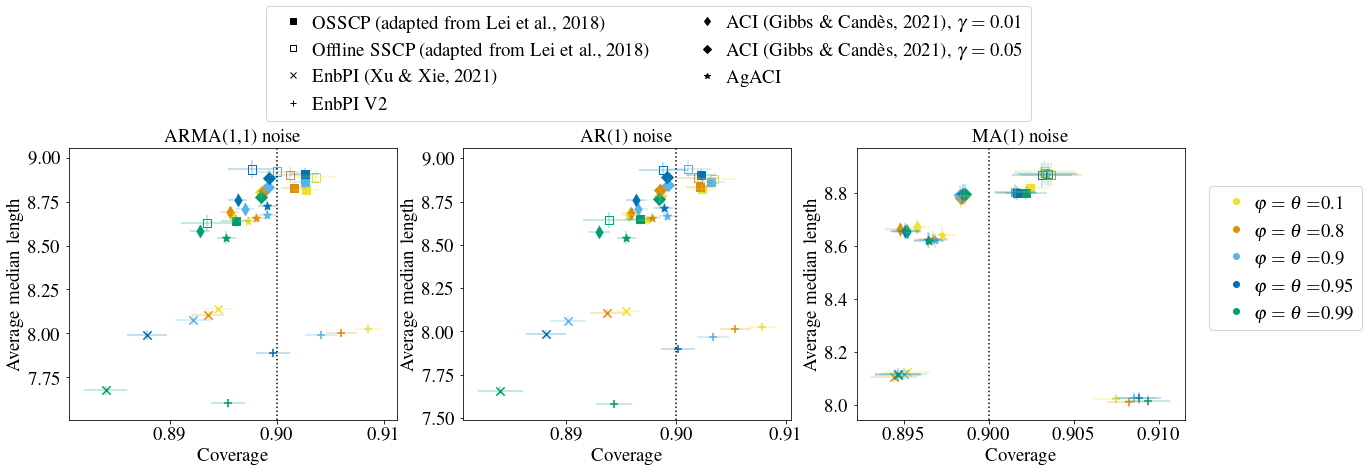

In [12]:
lines = False
add_offline = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5), sharex=False, sharey=False)

markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average median length")
ax1.set_title("ARMA(1,1) noise")

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average median length")
ax2.set_title("AR(1) noise")

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise)
            ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax3.axvline(x=1-alpha, color='black', ls=':')
ax3.set_xlabel("Coverage")
ax3.set_ylabel("Average median length")
ax3.set_title('MA(1) noise')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,
           ncol=2, bbox_to_anchor=(0.1,1.1,0.7,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))
 
if lines:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

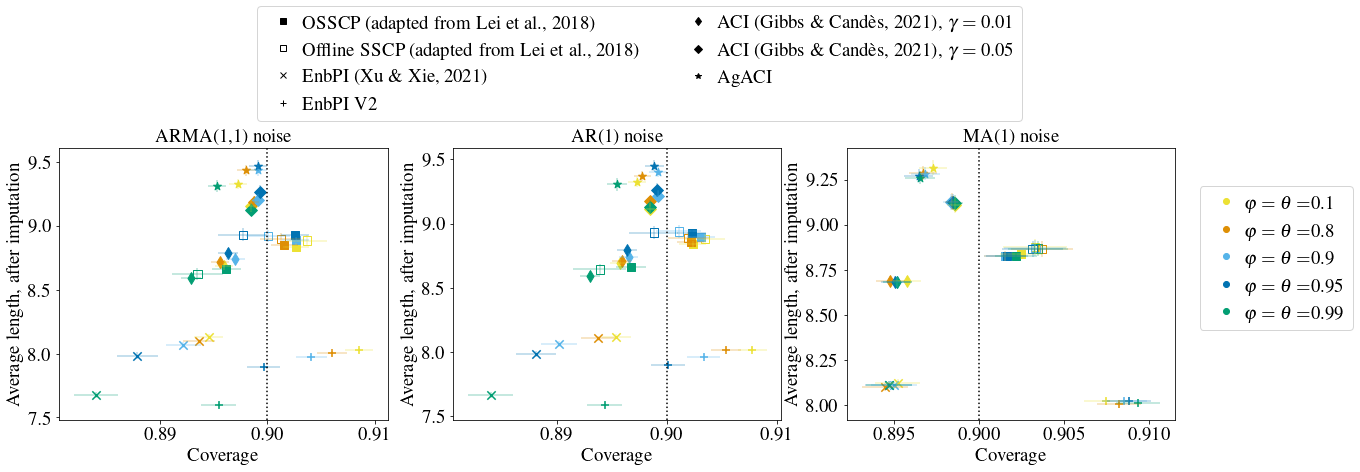

In [39]:
lines = False
add_offline = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP', 'EnbPI', 'EnbPI_Mean', 'ACP_0.01','ACP_0.05', 'Aggregation_BOA_Gradient']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5), sharex=False, sharey=False)

markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise,
                                                     impute=True)
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise,
                                                         impute=True)
            ax1.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average length, after imputation")
ax1.set_title("ARMA(1,1) noise")

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise,
                                                     impute=True)
        ax2.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise,
                                                         impute=True)
            ax2.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average length, after imputation")
ax2.set_title("AR(1) noise")

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise,
                                                     impute=True)
        ax3.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.mean(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax3.errorbar(np.mean(contains), np.mean(lengths),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_offline and method in Simples:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, online=False,
                                                         params_noise=params_noise,
                                                         impute=True)
            ax3.scatter(np.mean(contains),np.mean(lengths), 
                        marker=markers[method], color=colors[idx], facecolors='none',s=marker_size)
            lengths_std = np.std(np.mean(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax3.errorbar(np.mean(contains), np.mean(lengths),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax3.axvline(x=1-alpha, color='black', ls=':')
ax3.set_xlabel("Coverage")
ax3.set_ylabel("Average length, after imputation")
ax3.set_title('MA(1) noise')

# Methods legend

handles = []
names = list( map(methods_display.get, methods) )
if add_offline:
    names.insert(1,'Offline SSCP (adapted from Lei et al., 2018)')
for idm,marker in enumerate(list( map(markers.get, methods) )):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and idm == 0:
        handles.append(mlines.Line2D([], [], color='black', marker='s', linestyle='None', markerfacecolor='none'))
fig.legend(handles, names,
           ncol=2, bbox_to_anchor=(0.1,1.1,0.7,0.2),handletextpad=10**(-16))

# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))
 
if lines:
    name_plot = 'plots/synthetic/Friedman_Imputed_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_Imputed_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_offline :
    name_plot = name_plot + '_offline'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()

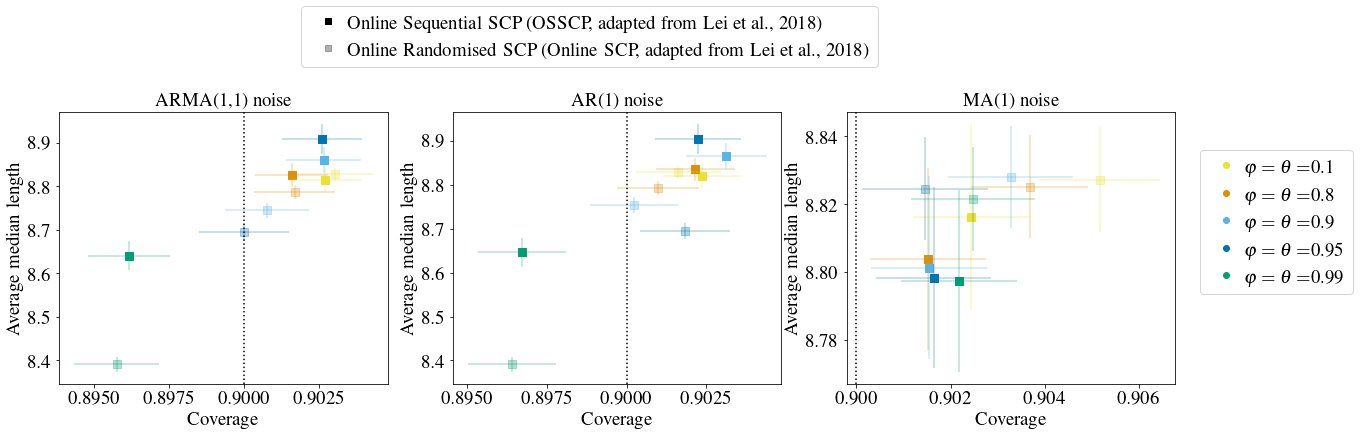

In [13]:
lines = False
add_randomized = True
Simples = ['CP']
ACPs = ['ACP_0.01','ACP_0.05'] 
methods = ['CP']
    
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5), sharex=False, sharey=False)

markers = {'CP': "s", 'ACP_0.05': "D",'ACP_0.01': "d", 'EnbPI': 'x','EnbPI_Mean': '+','Aggregation_BOA_Gradient':'*'}
methods_display = {'CP': 'OSSCP (adapted from Lei et al., 2018)', 
                   'EnbPI_Mean': 'EnbPI V2',
                   'ACP_0.01': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.01$',
                   'ACP_0.05': 'ACI (Gibbs \& Candès, 2021), '+r'$\gamma = 0.05$',
                   'Aggregation_BOA_Gradient':'AgACI',
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)'}
marker_size = 70

for idx, params_noise in enumerate(list_params_noise_arma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax1.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax1.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average median length")
ax1.set_title("ARMA(1,1) noise")

for idx, params_noise in enumerate(list_params_noise_ar):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax2.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax2.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax2.axvline(x=1-alpha, color='black', ls=':')
ax2.set_xlabel("Coverage")
ax2.set_ylabel("Average median length")
ax2.set_title("AR(1) noise")

for idx, params_noise in enumerate(list_params_noise_ma):  
    for method in methods:
        contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, params_noise=params_noise)
        ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                    marker=markers[method], color=colors[idx],s=marker_size)
        lengths_std = np.std(np.median(lengths,axis=1))
        coverage_std = np.std(np.mean(contains, axis=1))
        ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                     xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                     color=colors[idx], alpha=0.3)
        if add_randomized:
            contains, lengths = utils.compute_PI_metrics(method, n, train_size, n_rep, randomized=True,
                                                         params_noise=params_noise)
            ax3.scatter(np.mean(contains),np.mean(np.median(lengths,axis=1)), 
                        marker=markers[method], color=colors[idx], alpha=0.3,s=marker_size)
            lengths_std = np.std(np.median(lengths,axis=1))
            coverage_std = np.std(np.mean(contains, axis=1))
            ax3.errorbar(np.mean(contains), np.mean(np.median(lengths,axis=1)),
                         xerr=coverage_std/np.sqrt(n_rep),yerr=lengths_std/np.sqrt(n_rep), 
                         color=colors[idx], alpha=0.3)
ax3.axvline(x=1-alpha, color='black', ls=':')
ax3.set_xlabel("Coverage")
ax3.set_ylabel("Average median length")
ax3.set_title('MA(1) noise')

# Methods legend

if add_randomized:
    labels = ['Online Sequential SCP (OSSCP, adapted from Lei et al., 2018)', 
              'Online Randomised SCP (Online SCP, adapted from Lei et al., 2018)']
    handles = [mlines.Line2D([], [], color='black', marker="s", linestyle='None'),
               mlines.Line2D([], [], color='black', marker="s", linestyle='None', alpha=0.3)]
    fig.legend(handles, labels, bbox_to_anchor=(0.1,1,0.6,0.2),handletextpad=10**(-16))
    
# Noise legend

handles = []
labels = []
for idx,params_noise in enumerate(list_params_noise_arma):
    handles.append(mlines.Line2D([], [], color=colors[idx], marker="o", linestyle='None'))
    labels.append(r'$\varphi = \theta = $'+str(params_noise['ma'][1]))#+str(-params_noise['ar'][1])+
fig.legend(handles, labels, bbox_to_anchor=(1.03, 0.8),handletextpad=10**(-16))

if lines:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)+'_lines'
else:
    name_plot = 'plots/synthetic/Friedman_ARMA_AR_MA_var_'+str(var)+'_'+str(n_rep)
if add_randomized :
    name_plot = name_plot + '_randomized'
name_plot = name_plot + '_errtype'

plt.savefig(name_plot+'.pdf',bbox_inches='tight', dpi=300)

plt.show()